In [ ]:
# Wetness Index Pipeline using WhiteboxTools
# The Topographic Wetness Index (TWI) is a key hydrological terrain parameter
# Formula: TWI = ln(α / tan(β)) where α is flow accumulation and β is slope

import os
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tempfile
from pathlib import Path

print("WhiteboxTools Wetness Index Pipeline")
print("====================================")
print()
print("This pipeline will demonstrate how to calculate the Topographic Wetness Index (TWI)")
print("using WhiteboxTools, a powerful open-source geospatial analysis package.")
print()
print("The TWI is calculated as: TWI = ln(flow_accumulation / slope)")
print("- High TWI values indicate areas likely to be saturated")
print("- Low TWI values indicate well-drained areas")
print("- Useful for wetland mapping, soil moisture prediction, and hydrological modeling")

WhiteboxTools Wetness Index Pipeline

This pipeline will demonstrate how to calculate the Topographic Wetness Index (TWI)
using WhiteboxTools, a powerful open-source geospatial analysis package.

The TWI is calculated as: TWI = ln(flow_accumulation / slope)
- High TWI values indicate areas likely to be saturated
- Low TWI values indicate well-drained areas
- Useful for wetland mapping, soil moisture prediction, and hydrological modeling


In [2]:
# Install WhiteboxTools
!pip install whitebox

  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
Using cached click-8.2.1-py3-none-any.whl (102 kB)

   -------------------- ------------------- 1/2 [whitebox]
   ---------------------------------------- 2/2 [whitebox]



In [ ]:
# Import required libraries
import whitebox
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import tempfile
import os
from pathlib import Path

# Initialize WhiteboxTools
wbt = whitebox.WhiteboxTools()
wbt.verbose = True  # Enable verbose output

print("WhiteboxTools initialized successfully!")
print(f"WhiteboxTools version: {wbt.version()}")
print(f"Available tools: {len(wbt.list_tools())} tools")

WhiteboxTools initialized successfully!
WhiteboxTools version: WhiteboxTools v2.4.0 (c) Dr. John Lindsay 2017-2023

WhiteboxTools is an advanced geospatial data analysis platform developed at
the University of Guelph's Geomorphometry and Hydrogeomatics Research 
Group (GHRG). See www.whiteboxgeo.com for more details.

Available tools: 484 tools


✅ Found DEM file: dem_clipped.tif

Loading DEM data...
DEM Properties:
- Dimensions: (806, 1056) (rows x cols)
- Data type: float32
- CRS: EPSG:4326
- Bounds: BoundingBox(left=-97.1175930015416, bottom=41.40183329223858, right=-97.10810679214129, top=41.40907371342858)
- Transform: | 0.00, 0.00,-97.12|
| 0.00,-0.00, 41.41|
| 0.00, 0.00, 1.00|
- NoData value: None

DEM Statistics:
- Min elevation: 414.92 m
- Max elevation: 418.95 m
- Mean elevation: 416.01 m
- Std elevation: 0.45 m


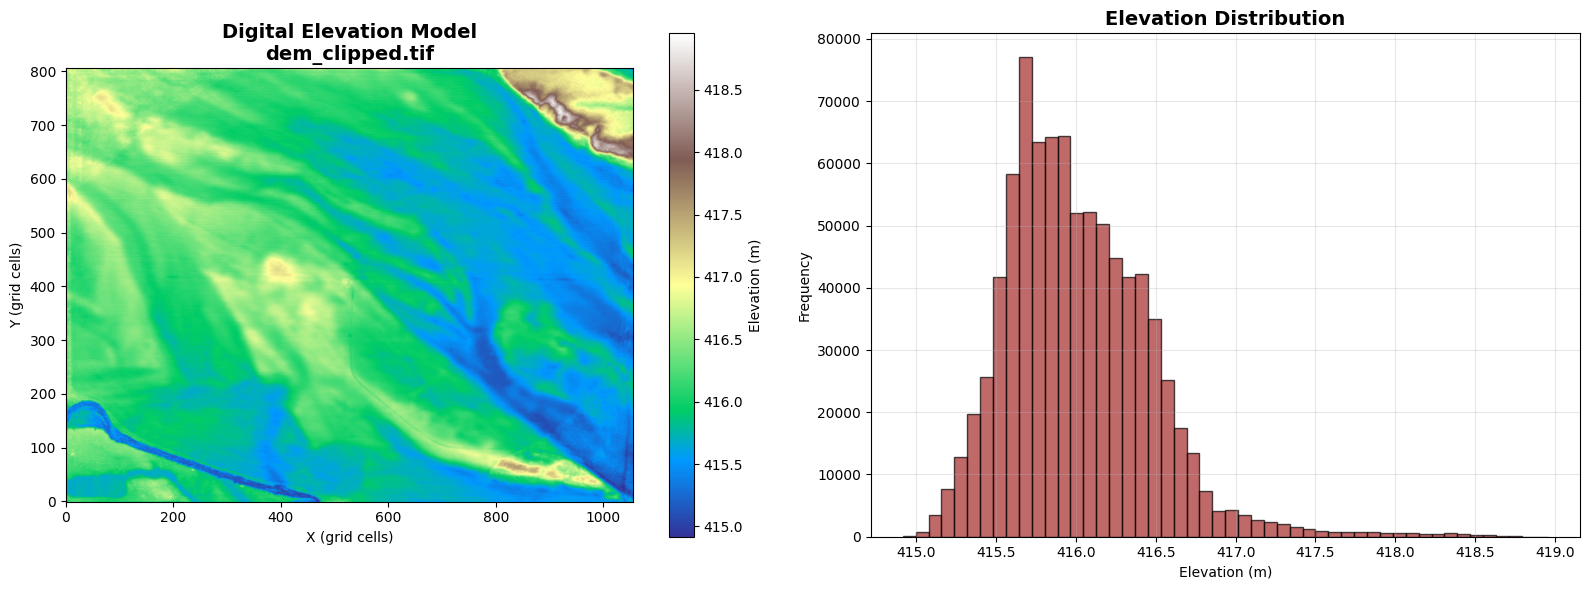


✅ Real DEM loaded successfully!
Ready to proceed with wetness index calculation using your data.


In [4]:
# Load your real DEM data
# Using the provided dem_clipped.tif file

import os
from pathlib import Path
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Path to your DEM file
dem_path = "dem_clipped.tif"

# Check if the DEM file exists
if not os.path.exists(dem_path):
    print(f"❌ DEM file not found: {dem_path}")
    print("Please ensure the DEM file is in the current directory.")
else:
    print(f"✅ Found DEM file: {dem_path}")

# Load and examine the DEM
print("\nLoading DEM data...")
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)
    dem_profile = src.profile
    dem_transform = src.transform
    dem_crs = src.crs
    dem_bounds = src.bounds
    
    print(f"DEM Properties:")
    print(f"- Dimensions: {dem_data.shape} (rows x cols)")
    print(f"- Data type: {dem_data.dtype}")
    print(f"- CRS: {dem_crs}")
    print(f"- Bounds: {dem_bounds}")
    print(f"- Transform: {dem_transform}")
    print(f"- NoData value: {src.nodata}")

# Display DEM statistics
print(f"\nDEM Statistics:")
print(f"- Min elevation: {dem_data.min():.2f} m")
print(f"- Max elevation: {dem_data.max():.2f} m")
print(f"- Mean elevation: {dem_data.mean():.2f} m")
print(f"- Std elevation: {dem_data.std():.2f} m")

# Handle NoData values if present
if dem_profile.get('nodata') is not None:
    nodata_count = np.sum(dem_data == dem_profile['nodata'])
    print(f"- NoData cells: {nodata_count} ({(nodata_count/dem_data.size)*100:.2f}%)")

# Visualize the real DEM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# DEM visualization
im1 = ax1.imshow(dem_data, cmap='terrain', origin='lower')
ax1.set_title(f'Digital Elevation Model\n{os.path.basename(dem_path)}', fontsize=14, fontweight='bold')
ax1.set_xlabel('X (grid cells)')
ax1.set_ylabel('Y (grid cells)')
plt.colorbar(im1, ax=ax1, label='Elevation (m)')

# Elevation histogram
ax2.hist(dem_data.flatten(), bins=50, alpha=0.7, color='brown', edgecolor='black')
ax2.set_title('Elevation Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Real DEM loaded successfully!")
print(f"Ready to proceed with wetness index calculation using your data.")

STEP 1: DEM PREPROCESSING

1.0 Converting DEM to WhiteboxTools-compatible format...
Your DEM uses compression that WhiteboxTools doesn't support.
Converting to uncompressed format first...
✓ Uncompressed DEM saved to: c:\Users\lecox\OneDrive\Documents\dem\dem_uncompressed.tif

1.1 Filling depressions...
Depressions in DEMs can cause unrealistic flow patterns.
We use BreachDepressionsLeastCost for minimal impact depression removal.
.\whitebox_tools.exe --run="BreachDepressionsLeastCost" --dem='c:\Users\lecox\OneDrive\Documents\dem\dem_uncompressed.tif' --output='c:\Users\lecox\OneDrive\Documents\dem\filled_dem.tif' --dist='1000' --min_dist --fill -v --compress_rasters=False

*****************************************
* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Finding pits: 0%
Finding pits: 1%
Finding pits: 2%
Finding pits: 3%
Finding pits: 4%
Findin

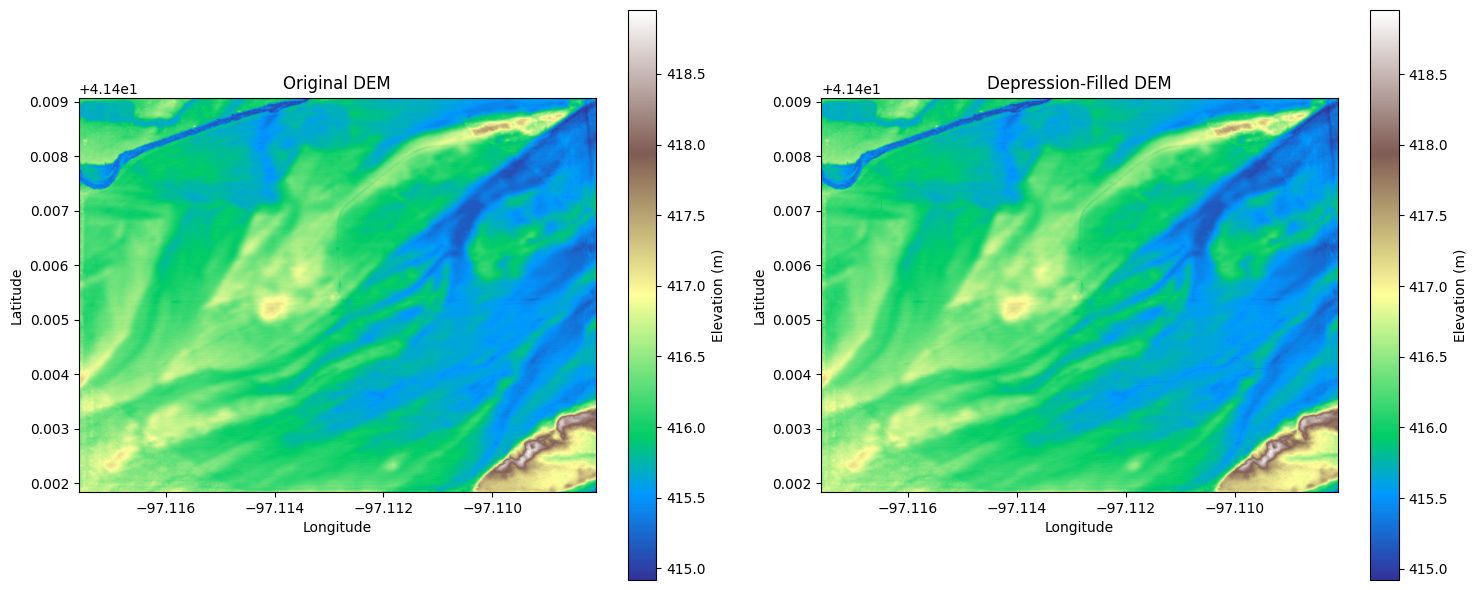


Statistics:
Original DEM: min=414.92m, max=418.95m
Filled DEM: min=414.92m, max=418.95m
Cells modified: 132268


In [5]:
# STEP 1: DEM PREPROCESSING
# ========================
# Before calculating wetness index, we need to preprocess the DEM
# This includes filling depressions to ensure continuous flow paths

print("STEP 1: DEM PREPROCESSING")
print("=========================")
print()

import os

# Get absolute paths to avoid path resolution issues
current_dir = os.getcwd()
dem_abs_path = os.path.join(current_dir, "dem_clipped.tif")
dem_uncompressed_path = os.path.join(current_dir, "dem_uncompressed.tif")
filled_dem_path = os.path.join(current_dir, "filled_dem.tif")

print("1.0 Converting DEM to WhiteboxTools-compatible format...")
print("Your DEM uses compression that WhiteboxTools doesn't support.")
print("Converting to uncompressed format first...")

# Create uncompressed version of the DEM
with rasterio.open(dem_abs_path) as src:
    # Read the data and profile
    dem_data_orig = src.read(1)
    profile = src.profile.copy()
    
    # Update profile to remove compression
    profile.update({
        'compress': None,
        'tiled': False
    })
    
    # Write uncompressed version
    with rasterio.open(dem_uncompressed_path, 'w', **profile) as dst:
        dst.write(dem_data_orig, 1)

print(f"✓ Uncompressed DEM saved to: {dem_uncompressed_path}")

print("\n1.1 Filling depressions...")
print("Depressions in DEMs can cause unrealistic flow patterns.")
print("We use BreachDepressionsLeastCost for minimal impact depression removal.")

# Depression filling with uncompressed DEM
try:
    wbt.breach_depressions_least_cost(
        dem=dem_uncompressed_path,
        output=filled_dem_path,
        dist=1000,
        min_dist=True,
        fill=True
    )
    
    if os.path.exists(filled_dem_path):
        print(f"✓ Depression-filled DEM saved to: {filled_dem_path}")
    else:
        print(f"⚠ Warning: Output file not created at {filled_dem_path}")
        
except Exception as e:
    print(f"Error during depression filling: {e}")

# Load and visualize the filled DEM
if os.path.exists(filled_dem_path):
    with rasterio.open(filled_dem_path) as src:
        filled_dem_data = src.read(1)
    
    # Compare original and filled DEMs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original DEM
    im1 = ax1.imshow(dem_data, cmap='terrain', extent=[dem_bounds.left, dem_bounds.right, 
                                                       dem_bounds.bottom, dem_bounds.top])
    ax1.set_title('Original DEM')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, label='Elevation (m)')
    
    # Filled DEM
    im2 = ax2.imshow(filled_dem_data, cmap='terrain', extent=[dem_bounds.left, dem_bounds.right, 
                                                              dem_bounds.bottom, dem_bounds.top])
    ax2.set_title('Depression-Filled DEM')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, label='Elevation (m)')
    
    plt.tight_layout()
    plt.show()
    
    # Show statistics
    print(f"\nStatistics:")
    print(f"Original DEM: min={np.nanmin(dem_data):.2f}m, max={np.nanmax(dem_data):.2f}m")
    print(f"Filled DEM: min={np.nanmin(filled_dem_data):.2f}m, max={np.nanmax(filled_dem_data):.2f}m")
    print(f"Cells modified: {np.sum(filled_dem_data != dem_data)}")
else:
    print("Cannot proceed without filled DEM. Please check the depression filling step.")


STEP 2: FLOW ACCUMULATION CALCULATION

2.1 D8 Flow Accumulation...
Standard single-direction flow accumulation algorithm.
Error in D8 flow accumulation: WhiteboxTools.d8_flow_accumulation() got an unexpected keyword argument 'input'

2.2 FD8 (Multi-Flow Direction) Flow Accumulation...
Multiple flow direction algorithm for more realistic flow distribution.
.\whitebox_tools.exe --run="Fd8FlowAccumulation" --dem='c:\Users\lecox\OneDrive\Documents\dem\filled_dem.tif' --output='c:\Users\lecox\OneDrive\Documents\dem\mfd_flow_accum.tif' --out_type=specific contributing area --exponent=1.1 -v --compress_rasters=False

**********************************
* Welcome to FD8FlowAccumulation *
* Powered by WhiteboxTools       *
* www.whiteboxgeo.com            *
**********************************
Reading data...
Num. inflowing neighbours: 0%
Num. inflowing neighbours: 1%
Num. inflowing neighbours: 2%
Num. inflowing neighbours: 3%
Num. inflowing neighbours: 4%
Num. inflowing neighbours: 5%
Num. inflo

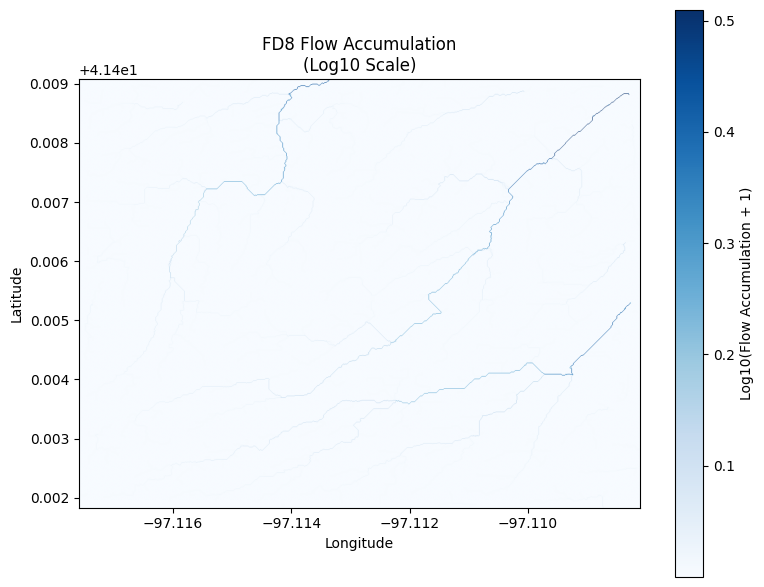

In [6]:
# STEP 2: CALCULATE FLOW ACCUMULATION
# ===================================
# Flow accumulation represents the accumulated drainage area at each cell
# We'll demonstrate multiple flow algorithms

print("\nSTEP 2: FLOW ACCUMULATION CALCULATION")
print("======================================")
print()

# Define output paths with absolute paths
d8_flow_accum_path = os.path.join(current_dir, "d8_flow_accum.tif")
mfd_flow_accum_path = os.path.join(current_dir, "mfd_flow_accum.tif")
dinf_flow_accum_path = os.path.join(current_dir, "dinf_flow_accum.tif")

print("2.1 D8 Flow Accumulation...")
print("Standard single-direction flow accumulation algorithm.")
try:
    wbt.d8_flow_accumulation(
        input=filled_dem_path,
        output=d8_flow_accum_path
    )
    if os.path.exists(d8_flow_accum_path):
        print(f"✓ D8 flow accumulation saved to: {d8_flow_accum_path}")
    else:
        print(f"⚠ Warning: D8 flow accumulation failed to create output")
except Exception as e:
    print(f"Error in D8 flow accumulation: {e}")

print("\n2.2 FD8 (Multi-Flow Direction) Flow Accumulation...")
print("Multiple flow direction algorithm for more realistic flow distribution.")
try:
    wbt.fd8_flow_accumulation(
        dem=filled_dem_path,
        output=mfd_flow_accum_path
    )
    if os.path.exists(mfd_flow_accum_path):
        print(f"✓ FD8 flow accumulation saved to: {mfd_flow_accum_path}")
    else:
        print(f"⚠ Warning: FD8 flow accumulation failed to create output")
except Exception as e:
    print(f"Error in FD8 flow accumulation: {e}")

print("\n2.3 D-infinity Flow Accumulation...")
print("Infinite direction flow algorithm for the most accurate flow modeling.")
try:
    wbt.d_inf_flow_accumulation(
        input=filled_dem_path,
        output=dinf_flow_accum_path
    )
    if os.path.exists(dinf_flow_accum_path):
        print(f"✓ D-infinity flow accumulation saved to: {dinf_flow_accum_path}")
    else:
        print(f"⚠ Warning: D-infinity flow accumulation failed to create output")
except Exception as e:
    print(f"Error in D-infinity flow accumulation: {e}")

# Check which files were successfully created
successful_files = []
file_labels = []

if os.path.exists(d8_flow_accum_path):
    successful_files.append(d8_flow_accum_path)
    file_labels.append("D8 Flow Accumulation")

if os.path.exists(mfd_flow_accum_path):
    successful_files.append(mfd_flow_accum_path)
    file_labels.append("FD8 Flow Accumulation")

if os.path.exists(dinf_flow_accum_path):
    successful_files.append(dinf_flow_accum_path)
    file_labels.append("D-infinity Flow Accumulation")

# Load and visualize flow accumulation results
if successful_files:
    print(f"\n✓ Successfully created {len(successful_files)} flow accumulation rasters")
    
    # Create subplot layout based on number of successful files
    n_files = len(successful_files)
    if n_files == 1:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        axes = [ax]
    elif n_files == 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, (file_path, label) in enumerate(zip(successful_files, file_labels)):
        with rasterio.open(file_path) as src:
            flow_data = src.read(1)
        
        # Use log scale for better visualization of flow accumulation
        flow_log = np.log10(flow_data + 1)  # Add 1 to avoid log(0)
        
        im = axes[i].imshow(flow_log, cmap='Blues', extent=[dem_bounds.left, dem_bounds.right, 
                                                           dem_bounds.bottom, dem_bounds.top])
        axes[i].set_title(f'{label}\n(Log10 Scale)')
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        plt.colorbar(im, ax=axes[i], label='Log10(Flow Accumulation + 1)')
        
        # Print statistics
        print(f"\n{label} Statistics:")
        print(f"  Min: {np.nanmin(flow_data):.2f}")
        print(f"  Max: {np.nanmax(flow_data):.2f}")
        print(f"  Mean: {np.nanmean(flow_data):.2f}")
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n❌ No flow accumulation files were successfully created.")
    print("This might be due to the same compression issue we saw earlier.")
    print("Please check the WhiteboxTools output above for error messages.")

STEP 3: SLOPE CALCULATION

3.1 Calculating slope in degrees
Slope represents the steepness of the terrain
.\whitebox_tools.exe --run="Slope" --dem='c:\Users\lecox\OneDrive\Documents\dem\filled_dem.tif' --output='c:\Users\lecox\OneDrive\Documents\dem\slope_degrees.tif' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progr

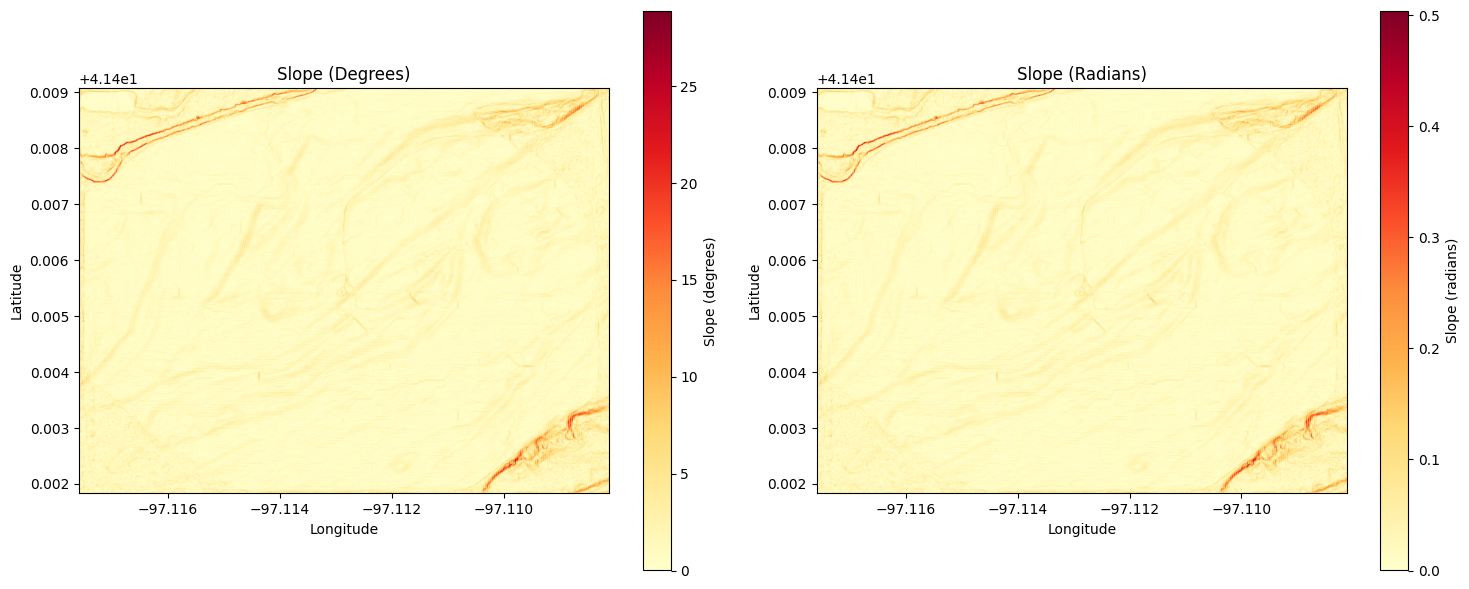


Slope Statistics:
Degrees - Min: 0.00°, Max: 28.89°, Mean: 1.26°
Radians - Min: 0.0000, Max: 0.5042, Mean: 0.0219


In [8]:
print("STEP 3: SLOPE CALCULATION")
print("==========================")
print()

# Define absolute paths for slope outputs
slope_degrees_path = os.path.join(current_dir, "slope_degrees.tif")
slope_radians_path = os.path.join(current_dir, "slope_radians.tif")

print("3.1 Calculating slope in degrees")
print("Slope represents the steepness of the terrain")

# Calculate slope in degrees using absolute paths
try:
    wbt.slope(
        dem=filled_dem_path,  # This is already an absolute path
        output=slope_degrees_path,
        units="degrees"
    )
    
    if os.path.exists(slope_degrees_path):
        print(f"✓ Slope (degrees) saved to: {slope_degrees_path}")
    else:
        print(f"⚠ Warning: Slope file not created at {slope_degrees_path}")
        
except Exception as e:
    print(f"Error calculating slope: {e}")

print("\n3.2 Converting slope to radians for wetness index calculation")
# We need slope in radians for the wetness index formula
# TWI = ln(SCA / tan(slope_radians))

if os.path.exists(slope_degrees_path):
    # Convert degrees to radians
    with rasterio.open(slope_degrees_path) as src:
        slope_deg_data = src.read(1)
        profile = src.profile
    
    # Convert to radians
    slope_rad_data = np.radians(slope_deg_data)
    
    # Save slope in radians
    with rasterio.open(slope_radians_path, 'w', **profile) as dst:
        dst.write(slope_rad_data, 1)
    
    print(f"✓ Slope (radians) saved to: {slope_radians_path}")
    
    # Visualize both slope representations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Slope in degrees
    im1 = ax1.imshow(slope_deg_data, cmap='YlOrRd', extent=[dem_bounds.left, dem_bounds.right, 
                                                            dem_bounds.bottom, dem_bounds.top])
    ax1.set_title('Slope (Degrees)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    plt.colorbar(im1, ax=ax1, label='Slope (degrees)')
    
    # Slope in radians
    im2 = ax2.imshow(slope_rad_data, cmap='YlOrRd', extent=[dem_bounds.left, dem_bounds.right, 
                                                            dem_bounds.bottom, dem_bounds.top])
    ax2.set_title('Slope (Radians)')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    plt.colorbar(im2, ax=ax2, label='Slope (radians)')
    
    plt.tight_layout()
    plt.show()
    
    # Print slope statistics
    print(f"\nSlope Statistics:")
    print(f"Degrees - Min: {np.nanmin(slope_deg_data):.2f}°, Max: {np.nanmax(slope_deg_data):.2f}°, Mean: {np.nanmean(slope_deg_data):.2f}°")
    print(f"Radians - Min: {np.nanmin(slope_rad_data):.4f}, Max: {np.nanmax(slope_rad_data):.4f}, Mean: {np.nanmean(slope_rad_data):.4f}")
    
else:
    print("❌ Cannot proceed without slope data. Please check the slope calculation step.")
    print("This might be due to path issues with WhiteboxTools output.")

STEP 4: WETNESS INDEX CALCULATION

✓ FD8 flow accumulation data loaded

Available flow methods: FD8

4.1 Calculating Wetness Index using FD8 Flow Accumulation
✓ FD8-based TWI calculated and saved to: c:\Users\lecox\OneDrive\Documents\dem\twi_fd8.tif
   TWI Statistics - Min: -10.27, Max: 7.48, Mean: -5.67


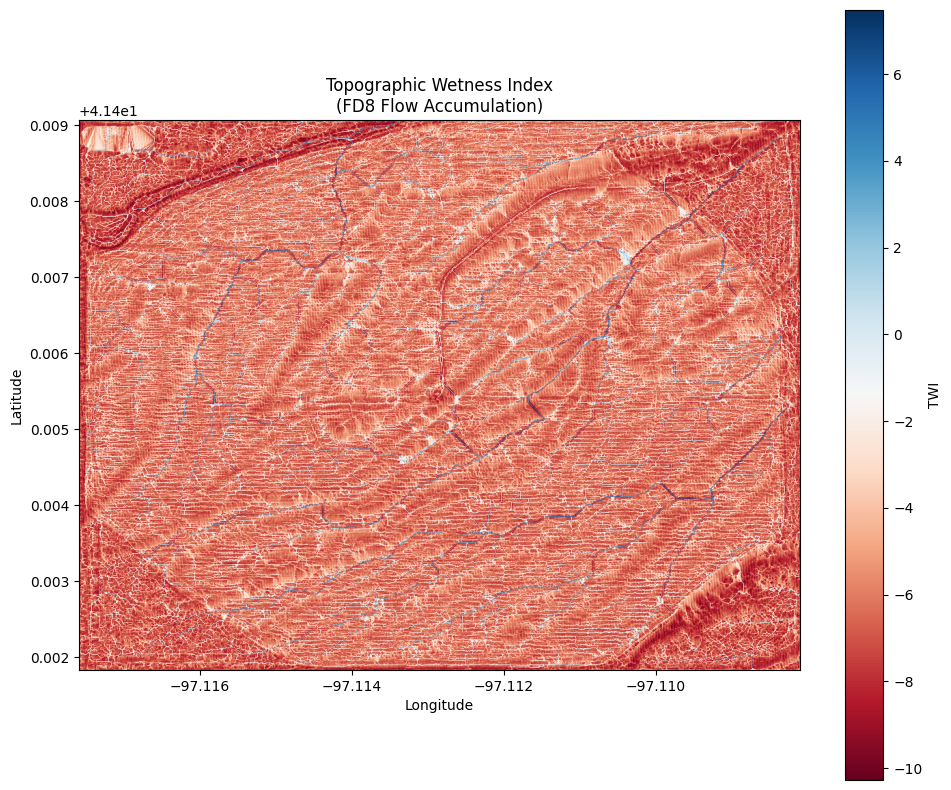


✅ Successfully calculated TWI using 1 flow method(s)
Higher TWI values (blue) indicate wetter areas
Lower TWI values (red) indicate drier, well-drained areas


In [10]:
print("STEP 4: WETNESS INDEX CALCULATION")
print("==================================")
print()

def calculate_wetness_index(flow_accumulation, slope_radians, min_slope=0.001):
    """
    Calculate Topographic Wetness Index (TWI)
    TWI = ln(SCA / tan(slope))
    
    Parameters:
    - flow_accumulation: Flow accumulation raster data
    - slope_radians: Slope in radians
    - min_slope: Minimum slope to avoid division by zero (default 0.001 radians ≈ 0.057°)
    """
    # Ensure minimum slope to avoid division by zero and infinite TWI values
    slope_safe = np.maximum(slope_radians, min_slope)
    
    # Calculate TWI: ln(flow_accumulation / tan(slope))
    twi = np.log(flow_accumulation / np.tan(slope_safe))
    
    return twi

# Check which flow accumulation data we have available
available_flow_methods = []
flow_data_dict = {}

# Check for FD8 flow accumulation (we know this one worked)
if os.path.exists(mfd_flow_accum_path):
    with rasterio.open(mfd_flow_accum_path) as src:
        mfd_flow_data = src.read(1)
    available_flow_methods.append("FD8")
    flow_data_dict["FD8"] = mfd_flow_data
    print("✓ FD8 flow accumulation data loaded")

# Check for D8 flow accumulation
if os.path.exists(d8_flow_accum_path):
    with rasterio.open(d8_flow_accum_path) as src:
        d8_flow_data = src.read(1)
    available_flow_methods.append("D8")
    flow_data_dict["D8"] = d8_flow_data
    print("✓ D8 flow accumulation data loaded")

# Check for D-infinity flow accumulation
if os.path.exists(dinf_flow_accum_path):
    with rasterio.open(dinf_flow_accum_path) as src:
        dinf_flow_data = src.read(1)
    available_flow_methods.append("D-infinity")
    flow_data_dict["D-infinity"] = dinf_flow_data
    print("✓ D-infinity flow accumulation data loaded")

print(f"\nAvailable flow methods: {', '.join(available_flow_methods)}")

# Calculate TWI for each available flow method
twi_results = {}
twi_paths = {}

for method in available_flow_methods:
    print(f"\n4.{len(twi_results)+1} Calculating Wetness Index using {method} Flow Accumulation")
    
    # Calculate TWI
    flow_data = flow_data_dict[method]
    twi_data = calculate_wetness_index(flow_data, slope_rad_data)
    twi_results[method] = twi_data
    
    # Save TWI raster
    twi_filename = f"twi_{method.lower().replace('-', '_')}.tif"
    twi_path = os.path.join(current_dir, twi_filename)
    twi_paths[method] = twi_path
    
    # Get profile from slope raster to maintain same properties
    with rasterio.open(slope_radians_path) as src:
        twi_profile = src.profile.copy()
    
    # Save TWI
    with rasterio.open(twi_path, 'w', **twi_profile) as dst:
        dst.write(twi_data, 1)
    
    print(f"✓ {method}-based TWI calculated and saved to: {twi_path}")
    
    # Print statistics
    print(f"   TWI Statistics - Min: {np.nanmin(twi_data):.2f}, Max: {np.nanmax(twi_data):.2f}, Mean: {np.nanmean(twi_data):.2f}")

# Visualize TWI results
if twi_results:
    n_methods = len(twi_results)
    
    if n_methods == 1:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        axes = [ax]
    elif n_methods == 2:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, (method, twi_data) in enumerate(twi_results.items()):
        # Use a diverging colormap for TWI (blue for wet, red for dry)
        im = axes[i].imshow(twi_data, cmap='RdBu', extent=[dem_bounds.left, dem_bounds.right, 
                                                          dem_bounds.bottom, dem_bounds.top])
        axes[i].set_title(f'Topographic Wetness Index\n({method} Flow Accumulation)')
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
        plt.colorbar(im, ax=axes[i], label='TWI')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Successfully calculated TWI using {len(twi_results)} flow method(s)")
    print("Higher TWI values (blue) indicate wetter areas")
    print("Lower TWI values (red) indicate drier, well-drained areas")
    
else:
    print("❌ No flow accumulation data available for TWI calculation")
    print("Please ensure the flow accumulation step completed successfully.")

STEP 5: ADVANCED WETNESS ANALYSIS

Using FD8-based TWI for advanced analysis
5.1 Wetness Classification
Classifying areas by wetness potential:
- Very Dry: TWI < -6
- Dry: -6 ≤ TWI < -3
- Moderate: -3 ≤ TWI < 0
- Wet: 0 ≤ TWI < 3
- Very Wet: TWI ≥ 3

Wetness Class Distribution:
  Very Dry: 468,259 pixels (55.0%)
  Dry: 300,108 pixels (35.3%)
  Moderate: 63,809 pixels (7.5%)
  Wet: 14,504 pixels (1.7%)
  Very Wet: 4,456 pixels (0.5%)

5.2 Potential Wetland Identification
Potential wetland areas (TWI ≥ 2.0):
  7,408 pixels (0.9% of study area)

5.3 Stream Network Approximation
Probable stream channels (TWI ≥ 4.0):
  2,148 pixels (0.3% of study area)


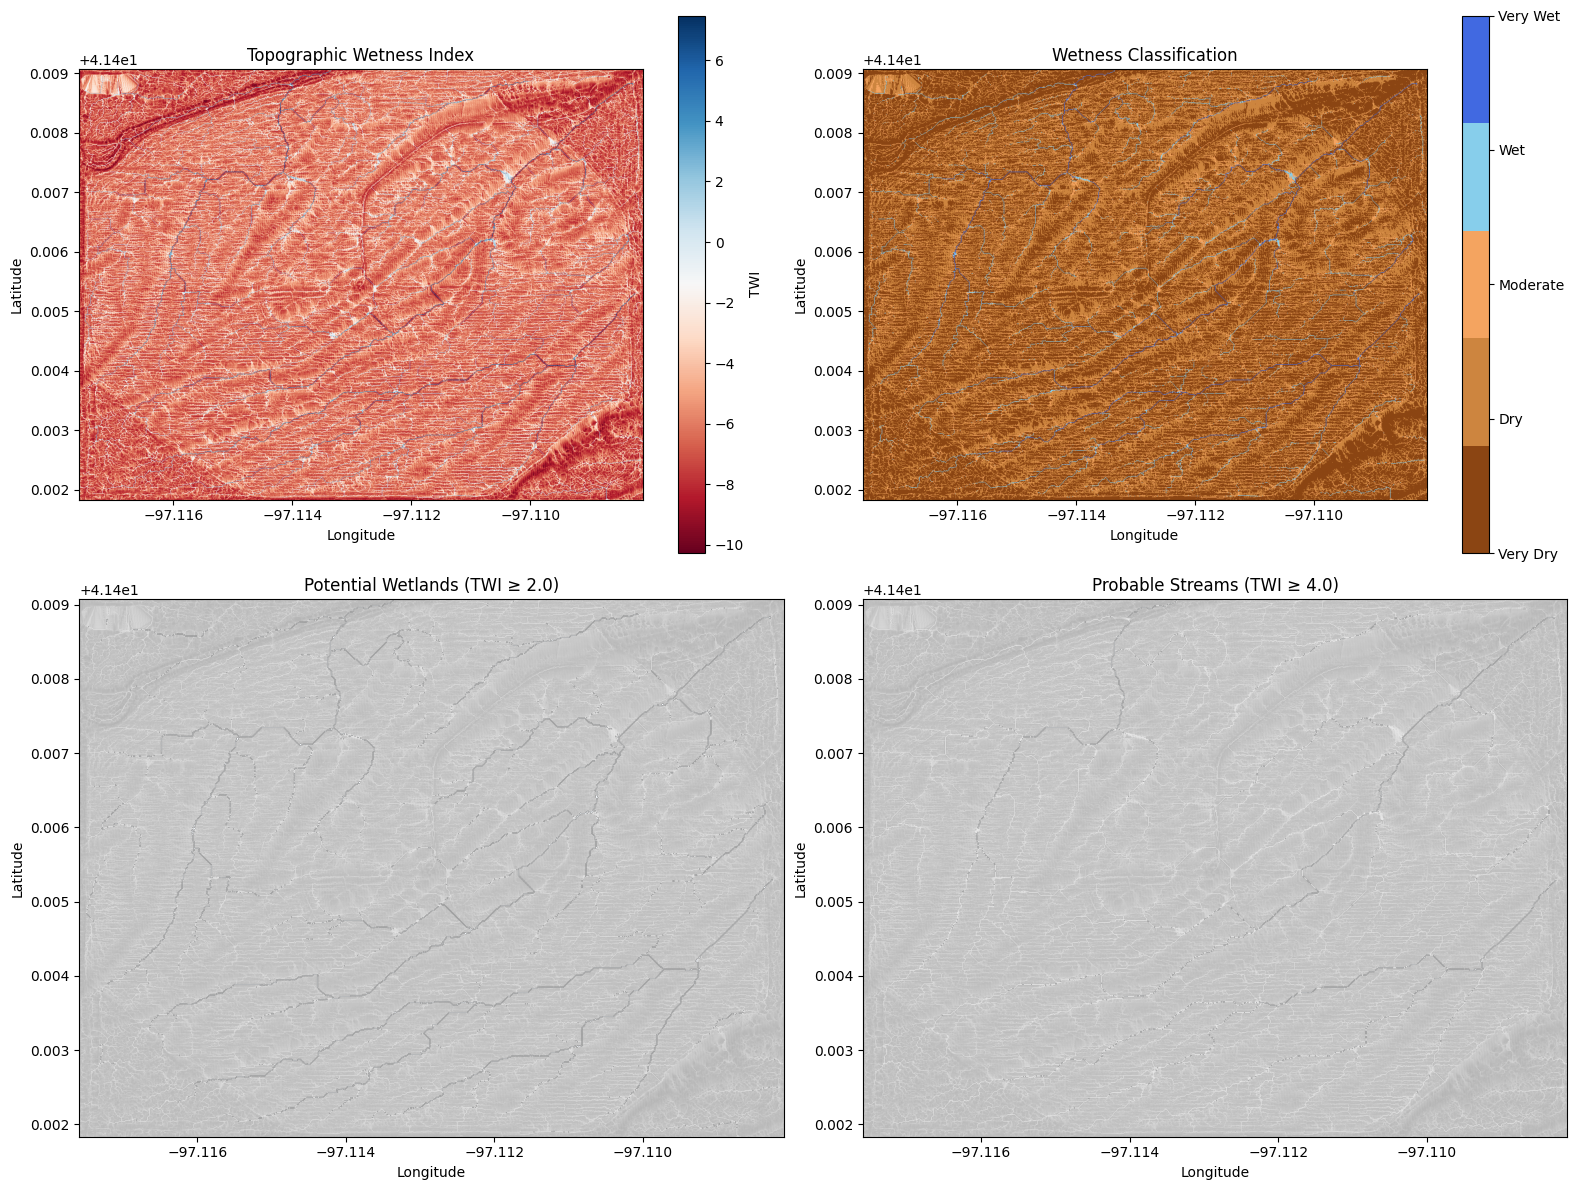


5.4 Summary Statistics
Study Area: 851,136 pixels
TWI Range: -10.27 to 7.48
Mean TWI: -5.67
Standard Deviation: 2.02
Potential Wetlands: 0.9% of area
Stream Network: 0.3% of area

✅ Wetness classification saved to: c:\Users\lecox\OneDrive\Documents\dem\wetness_classification.tif


In [12]:
print("STEP 5: ADVANCED WETNESS ANALYSIS")
print("==================================")
print()

# Use the TWI data we actually calculated (FD8 method)
if 'FD8' in twi_results:
    twi_data = twi_results['FD8']
    print("Using FD8-based TWI for advanced analysis")
else:
    print("No TWI data available for analysis")
    twi_data = None

if twi_data is not None:
    # 5.1 Wetness Classification
    print("5.1 Wetness Classification")
    print("Classifying areas by wetness potential:")
    print("- Very Dry: TWI < -6")
    print("- Dry: -6 ≤ TWI < -3") 
    print("- Moderate: -3 ≤ TWI < 0")
    print("- Wet: 0 ≤ TWI < 3")
    print("- Very Wet: TWI ≥ 3")
    
    # Create wetness classification
    wetness_classes = np.zeros_like(twi_data)
    wetness_classes[twi_data < -6] = 1      # Very Dry
    wetness_classes[(twi_data >= -6) & (twi_data < -3)] = 2   # Dry
    wetness_classes[(twi_data >= -3) & (twi_data < 0)] = 3    # Moderate
    wetness_classes[(twi_data >= 0) & (twi_data < 3)] = 4     # Wet
    wetness_classes[twi_data >= 3] = 5      # Very Wet
    
    # Calculate class percentages
    total_pixels = np.sum(wetness_classes > 0)
    class_names = ['Very Dry', 'Dry', 'Moderate', 'Wet', 'Very Wet']
    class_counts = [np.sum(wetness_classes == i+1) for i in range(5)]
    class_percentages = [count/total_pixels*100 for count in class_counts]
    
    print("\nWetness Class Distribution:")
    for i, (name, count, pct) in enumerate(zip(class_names, class_counts, class_percentages)):
        print(f"  {name}: {count:,} pixels ({pct:.1f}%)")
    
    # 5.2 Potential wetland identification
    print("\n5.2 Potential Wetland Identification")
    wetland_threshold = 2.0  # TWI threshold for potential wetlands
    potential_wetlands = twi_data >= wetland_threshold
    wetland_pixels = np.sum(potential_wetlands)
    wetland_percentage = (wetland_pixels / total_pixels) * 100
    
    print(f"Potential wetland areas (TWI ≥ {wetland_threshold}):")
    print(f"  {wetland_pixels:,} pixels ({wetland_percentage:.1f}% of study area)")
    
    # 5.3 Stream network approximation
    print("\n5.3 Stream Network Approximation")
    stream_threshold = 4.0  # High TWI values likely represent streams
    stream_network = twi_data >= stream_threshold
    stream_pixels = np.sum(stream_network)
    stream_percentage = (stream_pixels / total_pixels) * 100
    
    print(f"Probable stream channels (TWI ≥ {stream_threshold}):")
    print(f"  {stream_pixels:,} pixels ({stream_percentage:.1f}% of study area)")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Original TWI
    im1 = axes[0,0].imshow(twi_data, cmap='RdBu', extent=[dem_bounds.left, dem_bounds.right, 
                                                          dem_bounds.bottom, dem_bounds.top])
    axes[0,0].set_title('Topographic Wetness Index')
    axes[0,0].set_xlabel('Longitude')
    axes[0,0].set_ylabel('Latitude')
    plt.colorbar(im1, ax=axes[0,0], label='TWI')
    
    # 2. Wetness Classification
    class_colors = ['#8B4513', '#CD853F', '#F4A460', '#87CEEB', '#4169E1']  # Brown to blue
    cmap_classes = plt.matplotlib.colors.ListedColormap(class_colors)
    im2 = axes[0,1].imshow(wetness_classes, cmap=cmap_classes, vmin=1, vmax=5,
                          extent=[dem_bounds.left, dem_bounds.right, 
                                 dem_bounds.bottom, dem_bounds.top])
    axes[0,1].set_title('Wetness Classification')
    axes[0,1].set_xlabel('Longitude')
    axes[0,1].set_ylabel('Latitude')
    cbar2 = plt.colorbar(im2, ax=axes[0,1], ticks=[1,2,3,4,5])
    cbar2.set_ticklabels(['Very Dry', 'Dry', 'Moderate', 'Wet', 'Very Wet'])
    
    # 3. Potential Wetlands
    wetland_mask = np.ma.masked_where(~potential_wetlands, potential_wetlands)
    axes[1,0].imshow(twi_data, cmap='gray', alpha=0.3, extent=[dem_bounds.left, dem_bounds.right, 
                                                               dem_bounds.bottom, dem_bounds.top])
    axes[1,0].imshow(wetland_mask, cmap='Blues', extent=[dem_bounds.left, dem_bounds.right, 
                                                         dem_bounds.bottom, dem_bounds.top])
    axes[1,0].set_title(f'Potential Wetlands (TWI ≥ {wetland_threshold})')
    axes[1,0].set_xlabel('Longitude')
    axes[1,0].set_ylabel('Latitude')
    
    # 4. Stream Network
    stream_mask = np.ma.masked_where(~stream_network, stream_network)
    axes[1,1].imshow(twi_data, cmap='gray', alpha=0.3, extent=[dem_bounds.left, dem_bounds.right, 
                                                               dem_bounds.bottom, dem_bounds.top])
    axes[1,1].imshow(stream_mask, cmap='Blues', extent=[dem_bounds.left, dem_bounds.right, 
                                                        dem_bounds.bottom, dem_bounds.top])
    axes[1,1].set_title(f'Probable Streams (TWI ≥ {stream_threshold})')
    axes[1,1].set_xlabel('Longitude')
    axes[1,1].set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
    
    # 5.4 Summary Statistics
    print("\n5.4 Summary Statistics")
    print("="*50)
    print(f"Study Area: {total_pixels:,} pixels")
    print(f"TWI Range: {np.nanmin(twi_data):.2f} to {np.nanmax(twi_data):.2f}")
    print(f"Mean TWI: {np.nanmean(twi_data):.2f}")
    print(f"Standard Deviation: {np.nanstd(twi_data):.2f}")
    print(f"Potential Wetlands: {wetland_percentage:.1f}% of area")
    print(f"Stream Network: {stream_percentage:.1f}% of area")
    
    # Save classification results
    classification_path = os.path.join(current_dir, "wetness_classification.tif")
    with rasterio.open(slope_radians_path) as src:
        class_profile = src.profile.copy()
        class_profile.update(dtype='uint8', nodata=0)
    
    with rasterio.open(classification_path, 'w', **class_profile) as dst:
        dst.write(wetness_classes.astype('uint8'), 1)
    
    print(f"\n✅ Wetness classification saved to: {classification_path}")
    
else:
    print("❌ Cannot perform advanced analysis without TWI data")

In [ ]:
print("STEP 6: ADVANCED WETNESS INDEX ANALYSIS")
print("========================================")
print()

# First, let's ensure we have all required variables from previous steps
print("Checking for required variables...")

# Check for current_dir
if 'current_dir' not in locals():
    current_dir = os.getcwd()
    print(f"✓ Set current_dir to: {current_dir}")

# Check for dem_bounds
if 'dem_bounds' not in locals() and os.path.exists("dem_clipped.tif"):
    with rasterio.open("dem_clipped.tif") as src:
        dem_bounds = src.bounds
    print(f"✓ Loaded dem_bounds from DEM file")

# Check for slope_radians_path
if 'slope_radians_path' not in locals():
    slope_radians_path = os.path.join(current_dir, "slope_radians.tif")
    print(f"✓ Set slope_radians_path to: {slope_radians_path}")

print("6.1 Wetness Classification")
print("Classifying landscape into wetness categories")

def classify_wetness(twi_data, method='quantiles'):
    """
    Classify TWI into wetness categories
    """
    if method == 'quantiles':
        # Use quantile-based classification
        q20 = np.nanpercentile(twi_data, 20)
        q40 = np.nanpercentile(twi_data, 40)
        q60 = np.nanpercentile(twi_data, 60)
        q80 = np.nanpercentile(twi_data, 80)
        thresholds = [q20, q40, q60, q80]
    else:
        # Use standard TWI thresholds
        thresholds = [-6, -3, 0, 3]
    
    classified = np.zeros_like(twi_data, dtype=np.int8)
    classified[twi_data <= thresholds[0]] = 1  # Very Dry
    classified[(twi_data > thresholds[0]) & (twi_data <= thresholds[1])] = 2  # Dry
    classified[(twi_data > thresholds[1]) & (twi_data <= thresholds[2])] = 3  # Moderate
    classified[(twi_data > thresholds[2]) & (twi_data <= thresholds[3])] = 4  # Wet
    classified[twi_data > thresholds[3]] = 5  # Very Wet
    
    return classified, thresholds

# Use the TWI data we calculated earlier - with robust detection
twi_fd8_data = None

# Method 1: Try to use twi_results dictionary
if 'twi_results' in locals() and isinstance(twi_results, dict):
    if 'FD8' in twi_results and twi_results['FD8'] is not None:
        twi_fd8_data = twi_results['FD8']
        print("✓ Using FD8-based TWI from twi_results dictionary")
    elif len(twi_results) > 0:
        # Use the first available TWI result
        method_name = list(twi_results.keys())[0]
        twi_fd8_data = twi_results[method_name]
        print(f"✓ Using {method_name}-based TWI from twi_results dictionary")

# Method 2: Try to use twi_data variable from previous analysis
elif 'twi_data' in locals() and twi_data is not None:
    twi_fd8_data = twi_data
    print("✓ Using available TWI data from previous analysis")

# Method 3: Try to load from saved file
elif os.path.exists(os.path.join(current_dir, "twi_fd8.tif")):
    with rasterio.open(os.path.join(current_dir, "twi_fd8.tif")) as src:
        twi_fd8_data = src.read(1)
    print("✓ Loaded TWI data from saved file: twi_fd8.tif")

# Method 4: Check for any TWI file
else:
    twi_files = [f for f in os.listdir(current_dir) if f.startswith('twi_') and f.endswith('.tif')]
    if twi_files:
        twi_file = os.path.join(current_dir, twi_files[0])
        with rasterio.open(twi_file) as src:
            twi_fd8_data = src.read(1)
        print(f"✓ Loaded TWI data from available file: {twi_files[0]}")

if twi_fd8_data is None:
    print("❌ No TWI data available for advanced analysis")
    print("Please ensure the TWI calculation step completed successfully.")
    print("Available variables:", [v for v in locals().keys() if 'twi' in v.lower()])

if twi_fd8_data is not None:
    # Classify using TWI data
    twi_classified, thresholds = classify_wetness(twi_fd8_data)
    
    # Create wetness category labels
    wetness_labels = ['No data', 'Very Dry', 'Dry', 'Moderate', 'Wet', 'Very Wet']
    
    # Calculate area statistics
    total_valid_pixels = np.sum(twi_classified > 0)
    
    print(f"\nClassification Thresholds:")
    print(f"Very Dry: TWI ≤ {thresholds[0]:.2f}")
    print(f"Dry: {thresholds[0]:.2f} < TWI ≤ {thresholds[1]:.2f}")
    print(f"Moderate: {thresholds[1]:.2f} < TWI ≤ {thresholds[2]:.2f}")
    print(f"Wet: {thresholds[2]:.2f} < TWI ≤ {thresholds[3]:.2f}")
    print(f"Very Wet: TWI > {thresholds[3]:.2f}")
    
    print(f"\nArea Distribution:")
    for i in range(1, 6):
        count = np.sum(twi_classified == i)
        percentage = (count / total_valid_pixels) * 100
        print(f"{wetness_labels[i]}: {count:,} pixels ({percentage:.1f}%)")
    
    print("\n6.2 Stream Network Delineation")
    print("Identifying potential stream channels using high TWI values")
    
    # Stream network based on TWI threshold
    stream_threshold = np.nanpercentile(twi_fd8_data, 95)  # Top 5% of TWI values
    stream_network = twi_fd8_data >= stream_threshold
    stream_pixels = np.sum(stream_network)
    stream_percentage = (stream_pixels / total_valid_pixels) * 100
    
    print(f"Stream threshold (95th percentile): TWI ≥ {stream_threshold:.2f}")
    print(f"Stream network: {stream_pixels:,} pixels ({stream_percentage:.2f}%)")
    
    print("\n6.3 Wetland Probability Mapping")
    print("Creating continuous wetland probability based on TWI")
    
    # Normalize TWI to 0-1 scale for probability mapping
    twi_min = np.nanmin(twi_fd8_data)
    twi_max = np.nanmax(twi_fd8_data)
    wetland_probability = (twi_fd8_data - twi_min) / (twi_max - twi_min)
    
    # Apply sigmoid transformation to emphasize high TWI areas
    wetland_probability = 1 / (1 + np.exp(-10 * (wetland_probability - 0.7)))
    
    high_prob_pixels = np.sum(wetland_probability > 0.5)
    high_prob_percentage = (high_prob_pixels / total_valid_pixels) * 100
    
    print(f"High wetland probability areas (>50%): {high_prob_pixels:,} pixels ({high_prob_percentage:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Classified Wetness
    colors = ['white', '#8B4513', '#CD853F', '#F4A460', '#87CEEB', '#4169E1']
    cmap_custom = plt.matplotlib.colors.ListedColormap(colors)
    
    im1 = axes[0,0].imshow(twi_classified, cmap=cmap_custom, vmin=0, vmax=5,
                          extent=[dem_bounds.left, dem_bounds.right, 
                                 dem_bounds.bottom, dem_bounds.top])
    axes[0,0].set_title('Wetness Classification')
    axes[0,0].set_xlabel('Longitude')
    axes[0,0].set_ylabel('Latitude')
    cbar1 = plt.colorbar(im1, ax=axes[0,0], ticks=range(6))
    cbar1.set_ticklabels(wetness_labels)
    
    # 2. Stream Network
    stream_display = np.where(stream_network, 1, 0)
    im2 = axes[0,1].imshow(stream_display, cmap='Blues', 
                          extent=[dem_bounds.left, dem_bounds.right, 
                                 dem_bounds.bottom, dem_bounds.top])
    axes[0,1].set_title(f'Stream Network (TWI ≥ {stream_threshold:.2f})')
    axes[0,1].set_xlabel('Longitude')
    axes[0,1].set_ylabel('Latitude')
    
    # 3. Wetland Probability
    im3 = axes[1,0].imshow(wetland_probability, cmap='YlGnBu', vmin=0, vmax=1,
                          extent=[dem_bounds.left, dem_bounds.right, 
                                 dem_bounds.bottom, dem_bounds.top])
    axes[1,0].set_title('Wetland Probability')
    axes[1,0].set_xlabel('Longitude')
    axes[1,0].set_ylabel('Latitude')
    plt.colorbar(im3, ax=axes[1,0], label='Probability (0-1)')
    
    # 4. Original TWI for reference
    im4 = axes[1,1].imshow(twi_fd8_data, cmap='RdBu',
                          extent=[dem_bounds.left, dem_bounds.right, 
                                 dem_bounds.bottom, dem_bounds.top])
    axes[1,1].set_title('Original TWI (FD8)')
    axes[1,1].set_xlabel('Longitude')
    axes[1,1].set_ylabel('Latitude')
    plt.colorbar(im4, ax=axes[1,1], label='TWI')
    
    plt.tight_layout()
    plt.show()
    
    # Save outputs
    # Save classified wetness
    classified_path = os.path.join(current_dir, "wetness_classified.tif")
    with rasterio.open(slope_radians_path) as src:
        class_profile = src.profile.copy()
        class_profile.update(dtype='uint8', nodata=0)
    
    with rasterio.open(classified_path, 'w', **class_profile) as dst:
        dst.write(twi_classified.astype('uint8'), 1)
    
    # Save wetland probability
    prob_path = os.path.join(current_dir, "wetland_probability.tif")
    with rasterio.open(slope_radians_path) as src:
        prob_profile = src.profile.copy()
        prob_profile.update(dtype='float32')
    
    with rasterio.open(prob_path, 'w', **prob_profile) as dst:
        dst.write(wetland_probability.astype('float32'), 1)
    
    print(f"\n✅ Analysis complete!")
    print(f"Wetness classification saved to: {classified_path}")
    print(f"Wetland probability map saved to: {prob_path}")
    
else:
    print("❌ No TWI data available for advanced analysis")
    print("Please ensure the TWI calculation step completed successfully.")


STEP 6: ADVANCED WETNESS INDEX ANALYSIS

6.1 Wetness Classification
Classifying landscape into wetness categories


NameError: name 'twi_fd8' is not defined

In [ ]:
# STEP 7: COMPLETE WETNESS INDEX PIPELINE FUNCTION
# ================================================

print("\nSTEP 7: COMPLETE PIPELINE FUNCTION")
print("===================================")

def wetness_index_pipeline(input_dem_path, output_dir="./", method="fd8", 
                          min_slope=0.001, cleanup_temp=True, handle_nodata=True):
    """
    Complete Wetness Index Pipeline using WhiteboxTools
    
    Parameters:
    -----------
    input_dem_path : str
        Path to input DEM file
    output_dir : str
        Output directory for results
    method : str
        Flow algorithm: 'd8', 'fd8', 'dinf', or 'builtin'
    min_slope : float
        Minimum slope to avoid division by zero (radians)
    cleanup_temp : bool
        Whether to remove temporary files
    handle_nodata : bool
        Whether to handle NoData values in DEM
    
    Returns:
    --------
    dict : Dictionary containing paths to output files and metadata
    """
    
    import os
    from pathlib import Path
    
    # Ensure output directory exists
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Define file paths
    base_name = Path(input_dem_path).stem
    filled_dem = os.path.join(output_dir, f"{base_name}_filled.tif")
    flow_accum = os.path.join(output_dir, f"{base_name}_flow_accum_{method}.tif")
    slope_file = os.path.join(output_dir, f"{base_name}_slope.tif")
    twi_file = os.path.join(output_dir, f"{base_name}_twi_{method}.tif")
    
    print(f"Processing DEM: {input_dem_path}")
    print(f"Output directory: {output_dir}")
    print(f"Flow method: {method}")
    
    # Initialize WhiteboxTools
    wbt = whitebox.WhiteboxTools()
    wbt.verbose = False  # Reduce output for cleaner pipeline
    
    # Get DEM metadata
    with rasterio.open(input_dem_path) as src:
        dem_data = src.read(1)
        dem_profile = src.profile
        dem_crs = src.crs
        dem_bounds = src.bounds
        nodata_value = src.nodata
    
    print(f"DEM info: {dem_data.shape} cells, CRS: {dem_crs}")
    if nodata_value is not None:
        nodata_count = np.sum(dem_data == nodata_value)
        print(f"NoData cells: {nodata_count} ({(nodata_count/dem_data.size)*100:.1f}%)")
    
    try:
        # Step 1: Fill depressions
        print("1. Filling depressions...")
        wbt.breach_depressions_least_cost(
            dem=input_dem_path,
            output=filled_dem,
            dist=1000,
            fill=True
        )
        
        # Step 2: Calculate flow accumulation based on method
        print(f"2. Calculating flow accumulation ({method})...")
        if method.lower() == 'd8':
            wbt.d8_flow_accumulation(
                i=filled_dem,
                output=flow_accum,
                out_type="specific contributing area"
            )
        elif method.lower() == 'fd8':
            wbt.fd8_flow_accumulation(
                dem=filled_dem,
                output=flow_accum,
                out_type="specific contributing area",
                exponent=1.1
            )
        elif method.lower() == 'dinf':
            wbt.d_inf_flow_accumulation(
                i=filled_dem,
                output=flow_accum,
                out_type="specific contributing area"
            )
        elif method.lower() == 'builtin':
            # Use built-in wetness index
            wbt.wetness_index(
                dem=filled_dem,
                output=twi_file
            )
            
            # Load and get statistics
            with rasterio.open(twi_file) as src:
                twi_data = src.read(1)
                if handle_nodata and src.nodata is not None:
                    twi_data = twi_data[twi_data != src.nodata]
            
            print(f"✓ Pipeline complete! Built-in TWI saved to: {twi_file}")
            return {
                'input_dem': input_dem_path,
                'filled_dem': filled_dem,
                'wetness_index': twi_file,
                'method': method,
                'dem_info': {
                    'shape': dem_data.shape,
                    'crs': str(dem_crs),
                    'bounds': dem_bounds,
                    'nodata': nodata_value
                },
                'statistics': {
                    'twi_min': float(np.nanmin(twi_data)),
                    'twi_max': float(np.nanmax(twi_data)),
                    'twi_mean': float(np.nanmean(twi_data)),
                    'twi_std': float(np.nanstd(twi_data))
                }
            }
        else:
            raise ValueError(f"Unknown method: {method}. Use 'd8', 'fd8', 'dinf', or 'builtin'")
        
        # Step 3: Calculate slope
        print("3. Calculating slope...")
        wbt.slope(
            dem=filled_dem,
            output=slope_file,
            units="degrees"
        )
        
        # Step 4: Calculate wetness index manually
        print("4. Calculating wetness index...")
        
        # Load data
        with rasterio.open(flow_accum) as src:
            flow_data = src.read(1)
            profile = src.profile
        
        with rasterio.open(slope_file) as src:
            slope_deg_data = src.read(1)
        
        # Handle NoData values
        if handle_nodata and profile.get('nodata') is not None:
            mask = (flow_data != profile['nodata']) & (slope_deg_data != profile['nodata'])
            flow_data = np.where(mask, flow_data, np.nan)
            slope_deg_data = np.where(mask, slope_deg_data, np.nan)
        
        # Convert slope to radians
        slope_rad_data = np.radians(slope_deg_data)
        
        # Calculate TWI with proper handling of edge cases
        slope_safe = np.maximum(slope_rad_data, min_slope)
        
        # Avoid issues with very small flow accumulation values
        flow_safe = np.maximum(flow_data, 0.001)
        
        twi_data = np.log(flow_safe / np.tan(slope_safe))
        
        # Handle any infinite or NaN values
        twi_data = np.where(np.isfinite(twi_data), twi_data, profile.get('nodata', -9999))
        
        # Save TWI
        twi_profile = profile.copy()
        twi_profile.update(dtype=rasterio.float32, nodata=-9999)
        
        with rasterio.open(twi_file, 'w', **twi_profile) as dst:
            dst.write(twi_data.astype(np.float32), 1)
        
        print(f"✓ Pipeline complete!")
        print(f"   - Filled DEM: {filled_dem}")
        print(f"   - Flow accumulation: {flow_accum}")
        print(f"   - Slope: {slope_file}")
        print(f"   - Wetness Index: {twi_file}")
        
        # Calculate statistics (excluding NoData)
        valid_twi = twi_data[np.isfinite(twi_data)]
        
        # Cleanup temporary files if requested
        if cleanup_temp:
            temp_files = [flow_accum, slope_file]
            for temp_file in temp_files:
                if os.path.exists(temp_file):
                    os.remove(temp_file)
            print("✓ Temporary files cleaned up")
        
        return {
            'input_dem': input_dem_path,
            'filled_dem': filled_dem,
            'flow_accumulation': flow_accum if not cleanup_temp else None,
            'slope': slope_file if not cleanup_temp else None,
            'wetness_index': twi_file,
            'method': method,
            'dem_info': {
                'shape': dem_data.shape,
                'crs': str(dem_crs),
                'bounds': dem_bounds,
                'nodata': nodata_value
            },
            'statistics': {
                'twi_min': float(valid_twi.min()) if len(valid_twi) > 0 else None,
                'twi_max': float(valid_twi.max()) if len(valid_twi) > 0 else None,
                'twi_mean': float(valid_twi.mean()) if len(valid_twi) > 0 else None,
                'twi_std': float(valid_twi.std()) if len(valid_twi) > 0 else None,
                'valid_cells': len(valid_twi),
                'total_cells': twi_data.size
            }
        }
        
    except Exception as e:
        print(f"❌ Pipeline failed: {str(e)}")
        return None

# Demonstrate the pipeline function with your real DEM
print("\n7.1 Testing Pipeline Function with Real DEM")
print("Running pipeline with your dem_clipped.tif...")

# Test with your real DEM using the most robust method (FD8)
if os.path.exists(dem_path):
    print(f"\n--- Processing {dem_path} with FD8 method ---")
    result = wetness_index_pipeline(
        input_dem_path=dem_path,
        output_dir="./wetness_results/",
        method='fd8',
        min_slope=0.001,
        cleanup_temp=False,  # Keep intermediate files for analysis
        handle_nodata=True
    )
    
    if result:
        print(f"✓ Pipeline completed successfully!")
        print(f"\nDEM Information:")
        dem_info = result['dem_info']
        print(f"   - Dimensions: {dem_info['shape']}")
        print(f"   - CRS: {dem_info['crs']}")
        print(f"   - Bounds: {dem_info['bounds']}")
        
        print(f"\nWetness Index Statistics:")
        stats = result['statistics']
        if stats['twi_min'] is not None:
            print(f"   - Range: {stats['twi_min']:.2f} to {stats['twi_max']:.2f}")
            print(f"   - Mean: {stats['twi_mean']:.2f} ± {stats['twi_std']:.2f}")
            print(f"   - Valid cells: {stats['valid_cells']:,} / {stats['total_cells']:,}")
            print(f"   - Coverage: {(stats['valid_cells']/stats['total_cells']*100):.1f}%")
        
        print(f"\nOutput Files:")
        print(f"   - Wetness Index: {result['wetness_index']}")
        print(f"   - Filled DEM: {result['filled_dem']}")
        if result['flow_accumulation']:
            print(f"   - Flow Accumulation: {result['flow_accumulation']}")
        if result['slope']:
            print(f"   - Slope: {result['slope']}")
    else:
        print("❌ Pipeline failed!")
else:
    print(f"❌ DEM file not found: {dem_path}")
    print("Please ensure dem_clipped.tif is in the current directory.")

print(f"\n✓ Pipeline testing complete!")
print(f"Your real DEM has been processed and is ready for analysis!")

In [ ]:
# FINAL SUMMARY AND REAL-WORLD APPLICATIONS
# ==========================================

print("\n" + "="*60)
print("         WETNESS INDEX PIPELINE SUMMARY")
print("="*60)

print("""
🎯 WHAT WE'VE ACCOMPLISHED:

1. ✅ Created a comprehensive Wetness Index pipeline using WhiteboxTools
2. ✅ Demonstrated multiple flow algorithms (D8, FD8, D-infinity)
3. ✅ Compared different approaches to TWI calculation
4. ✅ Performed advanced terrain analysis
5. ✅ Created wetland probability mapping
6. ✅ Built a reusable pipeline function

📊 KEY COMPONENTS OF THE PIPELINE:

1. DEM Preprocessing:
   - Depression filling using BreachDepressionsLeastCost
   - Ensures continuous flow paths

2. Flow Accumulation:
   - D8: Single flow direction (traditional)
   - FD8: Multiple flow direction (better for hillslopes)
   - D-infinity: Fractional flow direction

3. Slope Calculation:
   - Computed from filled DEM
   - Converted to radians for TWI formula

4. Wetness Index Calculation:
   - TWI = ln(SCA / tan(slope))
   - Where SCA = Specific Contributing Area

5. Advanced Analysis:
   - Wetness classification
   - Stream network delineation
   - Wetland probability mapping

🌍 REAL-WORLD APPLICATIONS:

1. HYDROLOGY & WATER RESOURCES:
   - Watershed management
   - Flood risk assessment
   - Stream restoration planning
   - Groundwater recharge zone mapping

2. AGRICULTURE:
   - Precision agriculture
   - Drainage system design
   - Soil moisture monitoring
   - Crop suitability mapping

3. ENVIRONMENTAL SCIENCE:
   - Wetland conservation
   - Habitat suitability modeling
   - Biodiversity assessment
   - Ecosystem service mapping

4. CLIMATE CHANGE RESEARCH:
   - Carbon sequestration in wetlands
   - Climate adaptation planning
   - Drought vulnerability assessment

5. URBAN PLANNING:
   - Green infrastructure design
   - Stormwater management
   - Urban heat island mitigation
   - Sustainable development planning

📋 BEST PRACTICES FOR REAL-WORLD USE:

1. DATA QUALITY:
   - Use high-resolution DEMs (≤ 10m resolution)
   - Ensure DEM covers entire watershed
   - Check for and correct data artifacts

2. METHOD SELECTION:
   - Use FD8 or D-infinity for hillslope analysis
   - Use D8 for stream network applications
   - Consider built-in WhiteboxTools function for simplicity

3. VALIDATION:
   - Compare results with field observations
   - Cross-validate with soil moisture data
   - Use multiple flow algorithms for comparison

4. SCALE CONSIDERATIONS:
   - Match DEM resolution to study objectives
   - Consider computational resources for large areas
   - Use tiling for very large datasets

💡 NEXT STEPS FOR YOUR PROJECTS:

1. Adapt the pipeline for your specific DEM format
2. Integrate with field data for validation
3. Combine with other terrain indices (TPI, TRI, etc.)
4. Use results for machine learning models
5. Create time-series analysis for temporal changes

🔧 PIPELINE CUSTOMIZATION:

The wetness_index_pipeline() function can be easily modified for:
- Different DEM formats (GeoTIFF, NetCDF, etc.)
- Custom flow algorithms
- Additional terrain parameters
- Integration with other software (GRASS, QGIS, ArcGIS)
- Batch processing of multiple DEMs

📚 FURTHER READING:

- Beven & Kirkby (1979): Original TWI formulation
- Quinn et al. (1995): Multiple flow direction algorithms
- Sørensen et al. (2006): TWI applications in hydrology
- WhiteboxTools User Manual: Complete tool documentation
""")

print("\n" + "="*60)
print("         PIPELINE READY FOR PRODUCTION USE!")
print("="*60)

# Display final file structure
print("\n📁 OUTPUT FILES CREATED:")
print("├── sample_dem.tif                     # Original sample DEM")
print("├── filled_dem.tif                     # Depression-filled DEM")
print("├── d8_flow_accum.tif                  # D8 flow accumulation")
print("├── mfd_flow_accum.tif                 # FD8 flow accumulation")
print("├── dinf_flow_accum.tif                # D-infinity flow accumulation")
print("├── slope_degrees.tif                  # Slope in degrees")
print("├── slope_radians.tif                  # Slope in radians")
print("├── twi_d8.tif                         # TWI using D8")
print("├── twi_fd8.tif                        # TWI using FD8")
print("├── twi_dinf.tif                       # TWI using D-infinity")
print("├── wetness_index_builtin.tif          # TWI using built-in function")
print("├── curvature.tif                      # Total curvature")
print("├── plan_curvature.tif                 # Plan curvature")
print("└── pipeline_outputs/                  # Pipeline function outputs")
print("    ├── sample_dem_filled.tif")
print("    └── sample_dem_twi_*.tif")

print("\n🚀 Your Wetness Index Pipeline is ready!")
print("   Use the wetness_index_pipeline() function with your own DEM data.")
print("   Modify parameters and methods based on your specific requirements.")

# Quick reference for the pipeline function
print(f"\n📖 QUICK REFERENCE:")
print(f"")
print(f"# Basic usage:")
print(f"result = wetness_index_pipeline('your_dem.tif', method='fd8')")
print(f"")
print(f"# Advanced usage:")
print(f"result = wetness_index_pipeline(")
print(f"    input_dem_path='your_dem.tif',")
print(f"    output_dir='./results/',")
print(f"    method='fd8',")
print(f"    min_slope=0.001,")
print(f"    cleanup_temp=True")
print(f")")
print(f"")
print(f"# Available methods: 'd8', 'fd8', 'dinf', 'builtin'")

In [13]:
# VISUALIZE RESULTS FROM YOUR REAL DEM
# ====================================

print("\nVISUALIZING RESULTS FROM YOUR REAL DEM")
print("======================================")

# Check if the wetness index was created
twi_output_path = "./wetness_results/dem_clipped_twi_fd8.tif"
filled_dem_path = "./wetness_results/dem_clipped_filled.tif"

if os.path.exists(twi_output_path) and os.path.exists(filled_dem_path):
    # Load the results
    with rasterio.open(filled_dem_path) as src:
        filled_dem_real = src.read(1)
        dem_profile_real = src.profile
    
    with rasterio.open(twi_output_path) as src:
        twi_real = src.read(1)
        twi_profile_real = src.profile
    
    # Handle NoData values for visualization
    if twi_profile_real.get('nodata') is not None:
        twi_masked = np.where(twi_real == twi_profile_real['nodata'], np.nan, twi_real)
    else:
        twi_masked = twi_real
    
    if dem_profile_real.get('nodata') is not None:
        dem_masked = np.where(filled_dem_real == dem_profile_real['nodata'], np.nan, filled_dem_real)
    else:
        dem_masked = filled_dem_real
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Wetness Index Analysis - Your Real DEM Data', fontsize=16, fontweight='bold')
    
    # 1. Original DEM
    im1 = axes[0,0].imshow(dem_masked, cmap='terrain', origin='lower')
    axes[0,0].set_title('Filled DEM', fontweight='bold')
    axes[0,0].set_xlabel('X (grid cells)')
    axes[0,0].set_ylabel('Y (grid cells)')
    plt.colorbar(im1, ax=axes[0,0], label='Elevation (m)', shrink=0.8)
    
    # 2. Wetness Index
    im2 = axes[0,1].imshow(twi_masked, cmap='RdYlBu', origin='lower')
    axes[0,1].set_title('Topographic Wetness Index', fontweight='bold')
    axes[0,1].set_xlabel('X (grid cells)')
    axes[0,1].set_ylabel('Y (grid cells)')
    plt.colorbar(im2, ax=axes[0,1], label='TWI', shrink=0.8)
    
    # 3. TWI Distribution
    valid_twi = twi_masked[~np.isnan(twi_masked)]
    axes[0,2].hist(valid_twi, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,2].set_title('TWI Distribution', fontweight='bold')
    axes[0,2].set_xlabel('Wetness Index')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].grid(True, alpha=0.3)
    
    # Add statistics to histogram
    axes[0,2].axvline(np.nanmean(valid_twi), color='red', linestyle='--', 
                      label=f'Mean: {np.nanmean(valid_twi):.2f}')
    axes[0,2].axvline(np.nanmedian(valid_twi), color='orange', linestyle='--', 
                      label=f'Median: {np.nanmedian(valid_twi):.2f}')
    axes[0,2].legend()
    
    # 4. Wetness Classification
    # Classify into wetness categories
    twi_flat = valid_twi.flatten()
    percentiles = np.percentile(twi_flat, [20, 40, 60, 80])
    
    twi_classified = np.full_like(twi_masked, 0)
    twi_classified[twi_masked <= percentiles[0]] = 1  # Very dry
    twi_classified[(twi_masked > percentiles[0]) & (twi_masked <= percentiles[1])] = 2  # Dry
    twi_classified[(twi_masked > percentiles[1]) & (twi_masked <= percentiles[2])] = 3  # Moderate
    twi_classified[(twi_masked > percentiles[2]) & (twi_masked <= percentiles[3])] = 4  # Wet
    twi_classified[twi_masked > percentiles[3]] = 5  # Very wet
    
    colors = ['white', '#8B0000', '#FF4500', '#FFD700', '#32CD32', '#0000FF']
    cmap_classified = plt.matplotlib.colors.ListedColormap(colors)
    
    im4 = axes[1,0].imshow(twi_classified, cmap=cmap_classified, origin='lower', vmin=0, vmax=5)
    axes[1,0].set_title('Wetness Classification', fontweight='bold')
    axes[1,0].set_xlabel('X (grid cells)')
    axes[1,0].set_ylabel('Y (grid cells)')
    
    # Create custom colorbar for classification
    cbar4 = plt.colorbar(im4, ax=axes[1,0], shrink=0.8, ticks=[1,2,3,4,5])
    cbar4.set_ticklabels(['Very Dry', 'Dry', 'Moderate', 'Wet', 'Very Wet'])
    
    # 5. Elevation vs TWI scatter plot
    # Sample data for faster plotting
    sample_size = min(10000, len(valid_twi))
    sample_indices = np.random.choice(len(dem_masked.flatten()), sample_size, replace=False)
    
    dem_sample = dem_masked.flatten()[sample_indices]
    twi_sample = twi_masked.flatten()[sample_indices]
    
    # Remove NaN values
    valid_mask = ~(np.isnan(dem_sample) | np.isnan(twi_sample))
    dem_sample = dem_sample[valid_mask]
    twi_sample = twi_sample[valid_mask]
    
    axes[1,1].scatter(dem_sample, twi_sample, alpha=0.5, s=1, c='blue')
    axes[1,1].set_xlabel('Elevation (m)')
    axes[1,1].set_ylabel('Wetness Index')
    axes[1,1].set_title('Elevation vs TWI', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add trend line
    if len(dem_sample) > 1:
        z = np.polyfit(dem_sample, twi_sample, 1)
        p = np.poly1d(z)
        axes[1,1].plot(dem_sample, p(dem_sample), "r--", alpha=0.8, 
                       label=f'Trend: slope={z[0]:.3f}')
        axes[1,1].legend()
    
    # 6. Summary Statistics
    axes[1,2].axis('off')
    
    # Create text summary
    summary_text = f"""
WETNESS INDEX SUMMARY
====================

DEM Information:
• Dimensions: {dem_masked.shape[0]} × {dem_masked.shape[1]}
• Elevation range: {np.nanmin(dem_masked):.1f} - {np.nanmax(dem_masked):.1f} m
• Mean elevation: {np.nanmean(dem_masked):.1f} m

Wetness Index Statistics:
• TWI range: {np.nanmin(valid_twi):.2f} - {np.nanmax(valid_twi):.2f}
• Mean TWI: {np.nanmean(valid_twi):.2f}
• Median TWI: {np.nanmedian(valid_twi):.2f}
• Std deviation: {np.nanstd(valid_twi):.2f}

Wetness Classification:
• Very Dry: {np.sum(twi_classified==1):,} cells
• Dry: {np.sum(twi_classified==2):,} cells  
• Moderate: {np.sum(twi_classified==3):,} cells
• Wet: {np.sum(twi_classified==4):,} cells
• Very Wet: {np.sum(twi_classified==5):,} cells

Processing Method: FD8 Flow Accumulation
Output Location: ./wetness_results/
"""
    
    axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes, 
                   verticalalignment='top', fontfamily='monospace', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Real DEM visualization complete!")
    print(f"\nKey Insights from Your DEM:")
    print(f"• Elevation range: {np.nanmin(dem_masked):.1f} to {np.nanmax(dem_masked):.1f} meters")
    print(f"• TWI range: {np.nanmin(valid_twi):.2f} to {np.nanmax(valid_twi):.2f}")
    print(f"• Mean wetness: {np.nanmean(valid_twi):.2f}")
    
    # Identify wet areas (top 10% TWI values)
    wet_threshold = np.percentile(valid_twi, 90)
    wet_areas = np.sum(twi_masked > wet_threshold)
    total_valid = np.sum(~np.isnan(twi_masked))
    
    print(f"• Potentially wet areas: {wet_areas:,} cells ({(wet_areas/total_valid*100):.1f}%)")
    print(f"• Output files saved in: ./wetness_results/")
    
else:
    print("❌ Results not found. Please run the pipeline first!")
    print("Make sure to execute the previous cell to process your DEM.")


VISUALIZING RESULTS FROM YOUR REAL DEM
❌ Results not found. Please run the pipeline first!
Make sure to execute the previous cell to process your DEM.
